In [ ]:
import pandas as pd

# Load the dataset into a pandas DataFrame
df = pd.read_excel('/content/dataset.xlsx')

# Print the dataset description
display(df.describe())

,No.,Laser Power (W),Scan Speed (mm/s),Hatch space (mm),Layer thickness (mm),Spot size (mm),Geometric Factor,D50 μm,RD (%)
count,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000,1579.000000
mean,790.000000,236.927169,928.191288,0.104616,0.039516,0.104777,31.776353,32.452811,96.302643
std,455.962352,121.529338,580.133740,0.062043,0.033946,0.080744,22.126648,7.172917,5.483661
min,1.000000,30.000000,18.760000,0.018000,0.020000,0.025000,0.999603,14.630000,34.839200
25%,395.500000,150.000000,600.000000,0.080000,0.030000,0.070000,17.989320,28.850000,95.866957
50%,790.000000,200.000000,800.000000,0.100000,0.030000,0.080000,24.999987,31.060410,98.210000
75%,1184.500000,305.000000,1200.000000,0.120000,0.040000,0.100000,37.980873,36.690000,99.216412
max,1579.000000,950.000000,10000.000000,0.800000,0.460000,0.400000,89.994683,68.000000,100.000000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from scipy import stats
from scipy.stats import jarque_bera, shapiro
import warnings
warnings.filterwarnings('ignore')

# Remove the 'No.' column as it's just an index and not a meaningful feature
if 'No.' in df.columns:
    df = df.drop('No.', axis=1)
    print("Removed 'No.' column from dataset")
else:
    print("'No.' column not found in dataset")

# Assuming df is already loaded
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

Removed 'No.' column from dataset
Dataset Shape: (1579, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579 entries, 0 to 1578
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Material                    1579 non-null   object 
 1   Density Measurement Method  1579 non-null   object 
 2   Atmosphere                  1579 non-null   object 
 3   Printed Geom.               1579 non-null   object 
 4   Laser Power (W)             1579 non-null   float64
 5   Scan Speed (mm/s)           1579 non-null   float64
 6   Hatch space (mm)            1579 non-null   float64
 7   Layer thickness (mm)        1579 non-null   float64
 8   Spot size (mm)              1579 non-null   float64
 9   Geometric Factor            1579 non-null   float64
 10  D50 μm                      1579 non-null   float64
 11  RD (%)                      1579 non-null   float64
 12  Printer Model  

In [ ]:
# ============================================================================
# 1. ADVANCED OUTLIER DETECTION AND HANDLING
# ============================================================================

def advanced_outlier_detection(df, method='isolation_forest'):
    """
    Advanced outlier detection using multiple methods
    """
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.covariance import EllipticEnvelope

    print("=== ADVANCED OUTLIER DETECTION ===")

    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    outlier_results = {}

    if method == 'isolation_forest':
        # Isolation Forest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        outliers_iso = iso_forest.fit_predict(df[numeric_cols])
        outlier_results['isolation_forest'] = outliers_iso

    elif method == 'local_outlier_factor':
        # Local Outlier Factor
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
        outliers_lof = lof.fit_predict(df[numeric_cols])
        outlier_results['lof'] = outliers_lof

    elif method == 'elliptic_envelope':
        # Elliptic Envelope
        ee = EllipticEnvelope(contamination=0.1, random_state=42)
        outliers_ee = ee.fit_predict(df[numeric_cols])
        outlier_results['elliptic_envelope'] = outliers_ee

    # Statistical outlier detection (IQR method for each feature)
    def iqr_outlier_detection(data):
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return (data < lower_bound) | (data > upper_bound)

    # Apply IQR to each numeric column
    iqr_outliers = pd.DataFrame()
    for col in numeric_cols:
        iqr_outliers[col] = iqr_outlier_detection(df[col])

    # Combine outlier detection results
    if outlier_results:
        outlier_mask = outlier_results[list(outlier_results.keys())[0]] == -1
        print(f"Outliers detected by {method}: {np.sum(outlier_mask)}")

    # Show outlier summary by feature
    print("\nOutliers per feature (IQR method):")
    for col in numeric_cols:
        outlier_count = iqr_outliers[col].sum()
        outlier_percentage = (outlier_count / len(df)) * 100
        print(f"{col}: {outlier_count} ({outlier_percentage:.2f}%)")

    return outlier_results, iqr_outliers

# Apply outlier detection
outlier_results, iqr_outliers = advanced_outlier_detection(df, method='isolation_forest')



=== ADVANCED OUTLIER DETECTION ===
Outliers detected by isolation_forest: 158

Outliers per feature (IQR method):
Laser Power (W): 28 (1.77%)
Scan Speed (mm/s): 46 (2.91%)
Hatch space (mm): 59 (3.74%)
Layer thickness (mm): 100 (6.33%)
Spot size (mm): 227 (14.38%)
Geometric Factor: 165 (10.45%)
D50 μm: 67 (4.24%)
RD (%): 173 (10.96%)


In [ ]:
# ============================================================================
# 2. FEATURE ENGINEERING - DOMAIN-SPECIFIC FEATURES
# ============================================================================

def create_lpbf_features(df):
    """
    Create domain-specific features for LPBF process
    """
    print("\n=== CREATING DOMAIN-SPECIFIC FEATURES ===")

    df_enhanced = df.copy()

    # Energy density calculation (critical parameter in LPBF)
    # Energy Density = Laser Power / (Scan Speed × Hatch Space × Layer Thickness)
    df_enhanced['Energy_Density'] = (df['Laser Power (W)'] /
                                   (df['Scan Speed (mm/s)'] *
                                    df['Hatch space (mm)'] *
                                    df['Layer thickness (mm)']))

    # Linear energy density
    df_enhanced['Linear_Energy_Density'] = df['Laser Power (W)'] / df['Scan Speed (mm/s)']

    # Areal energy density
    df_enhanced['Areal_Energy_Density'] = (df['Laser Power (W)'] /
                                         (df['Scan Speed (mm/s)'] * df['Hatch space (mm)']))

    # Thermal diffusion length (related to heat affected zone)
    # Simplified formula: sqrt(thermal_diffusivity * layer_thickness / scan_speed)
    # Using normalized values for demonstration
    df_enhanced['Thermal_Diffusion_Length'] = np.sqrt(df['Layer thickness (mm)'] /
                                                     df['Scan Speed (mm/s)'])

    # Overlap ratio between adjacent tracks
    df_enhanced['Track_Overlap_Ratio'] = df_enhanced['Spot size (mm)'] / df['Hatch space (mm)']

    # Power-to-speed ratio
    df_enhanced['Power_Speed_Ratio'] = df['Laser Power (W)'] / df['Scan Speed (mm/s)']

    # Geometric factor interaction
    df_enhanced['Geometric_Interaction'] = (df['Hatch space (mm)'] *
                                          df['Layer thickness (mm)'] *
                                          df['Spot size (mm)'])

    print(f"Added {len(df_enhanced.columns) - len(df.columns)} new engineered features")
    print("New features:", [col for col in df_enhanced.columns if col not in df.columns])

    return df_enhanced

# Create enhanced features
df_enhanced = create_lpbf_features(df)




=== CREATING DOMAIN-SPECIFIC FEATURES ===
Added 7 new engineered features
New features: ['Energy_Density', 'Linear_Energy_Density', 'Areal_Energy_Density', 'Thermal_Diffusion_Length', 'Track_Overlap_Ratio', 'Power_Speed_Ratio', 'Geometric_Interaction']


In [ ]:
# ============================================================================
# 3. ADVANCED NORMALITY TESTING AND TRANSFORMATION
# ============================================================================

def advanced_normality_analysis(df, target_col='RD (%)'):
    """
    Comprehensive normality analysis and transformation
    """
    print("\n=== NORMALITY ANALYSIS AND TRANSFORMATION ===")

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    transformation_results = {}

    # Test normality for each feature
    normality_results = {}
    for col in numeric_cols:
        if col != target_col:
            # Shapiro-Wilk test (for smaller samples)
            if len(df) <= 5000:
                stat, p_value = shapiro(df[col].dropna())
                test_name = 'Shapiro-Wilk'
            else:
                # Jarque-Bera test (for larger samples)
                stat, p_value = jarque_bera(df[col].dropna())
                test_name = 'Jarque-Bera'

            normality_results[col] = {
                'test': test_name,
                'statistic': stat,
                'p_value': p_value,
                'is_normal': p_value > 0.05,
                'skewness': df[col].skew(),
                'kurtosis': df[col].kurtosis()
            }

    # Apply transformations to non-normal features
    transformer_options = {
        'yeo_johnson': PowerTransformer(method='yeo-johnson'),
        'box_cox': PowerTransformer(method='box-cox'),
        'log': lambda x: np.log1p(x - x.min() + 1),
        'sqrt': lambda x: np.sqrt(x - x.min() + 1),
        'reciprocal': lambda x: 1 / (x + 1)
    }

    print("\nNormality Test Results:")
    print("-" * 80)
    for col, result in normality_results.items():
        print(f"{col:25} | {result['test']:15} | p-value: {result['p_value']:.6f} | "
              f"Normal: {result['is_normal']} | Skew: {result['skewness']:.3f}")

    # Apply best transformation for non-normal features
    df_transformed = df.copy()

    for col in numeric_cols:
        if col != target_col and not normality_results[col]['is_normal']:
            best_transform = None
            best_score = float('inf')

            original_data = df[col].dropna()

            for transform_name, transformer in transformer_options.items():
                try:
                    if transform_name in ['yeo_johnson', 'box_cox']:
                        if transform_name == 'box_cox' and (original_data <= 0).any():
                            continue  # Box-Cox requires positive values
                        transformed_data = transformer.fit_transform(original_data.values.reshape(-1, 1)).flatten()
                    else:
                        transformed_data = transformer(original_data)

                    # Test normality of transformed data
                    if len(transformed_data) <= 5000:
                        _, p_val = shapiro(transformed_data)
                    else:
                        _, p_val = jarque_bera(transformed_data)

                    # Score based on p-value (higher is better for normality)
                    score = -p_val  # Negative because we want to maximize p-value

                    if score < best_score:
                        best_score = score
                        best_transform = (transform_name, transformer, transformed_data)

                except Exception as e:
                    continue

            if best_transform:
                transform_name, transformer, transformed_data = best_transform
                df_transformed[f'{col}_transformed'] = np.nan
                df_transformed.loc[original_data.index, f'{col}_transformed'] = transformed_data
                transformation_results[col] = transform_name
                print(f"Applied {transform_name} transformation to {col}")

    return df_transformed, normality_results, transformation_results

# Apply normality analysis and transformation
df_transformed, normality_results, transformation_results = advanced_normality_analysis(df_enhanced)




=== NORMALITY ANALYSIS AND TRANSFORMATION ===

Normality Test Results:
--------------------------------------------------------------------------------
Laser Power (W)           | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 1.371
Scan Speed (mm/s)         | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 3.711
Hatch space (mm)          | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 4.961
Layer thickness (mm)      | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 8.443
Spot size (mm)            | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 2.845
Geometric Factor          | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 1.308
D50 μm                    | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 1.073
Energy_Density            | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 4.527
Linear_Energy_Density     | Shapiro-Wilk    | p-value: 0.000000 | Normal: False | Skew: 7.874
A

In [ ]:
# ============================================================================
# 4. ADVANCED FEATURE SCALING
# ============================================================================

def advanced_scaling(df, target_col='RD (%)', scaling_method='robust'):
    """
    Apply advanced scaling methods suitable for manufacturing data
    """
    print(f"\n=== APPLYING {scaling_method.upper()} SCALING ===")

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col != target_col]

    df_scaled = df.copy()

    if scaling_method == 'robust':
        # Robust scaling (less sensitive to outliers)
        scaler = RobustScaler()
        df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

    elif scaling_method == 'standard':
        # Standard scaling
        scaler = StandardScaler()
        df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

    elif scaling_method == 'quantile_uniform':
        # Quantile transformation to uniform distribution
        from sklearn.preprocessing import QuantileTransformer
        scaler = QuantileTransformer(output_distribution='uniform')
        df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

    elif scaling_method == 'quantile_normal':
        # Quantile transformation to normal distribution
        from sklearn.preprocessing import QuantileTransformer
        scaler = QuantileTransformer(output_distribution='normal')
        df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

    print(f"Applied {scaling_method} scaling to {len(feature_cols)} features")
    return df_scaled, scaler

# Apply robust scaling (recommended for manufacturing data with outliers)
df_scaled, scaler = advanced_scaling(df_transformed, scaling_method='robust')




=== APPLYING ROBUST SCALING ===
Applied robust scaling to 28 features


In [ ]:
# ============================================================================
# 5. ADVANCED FEATURE SELECTION
# ============================================================================

def advanced_feature_selection(df, target_col='RD (%)', n_features=10):
    """
    Comprehensive feature selection using multiple methods
    """
    print(f"\n=== ADVANCED FEATURE SELECTION ===")

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col != target_col]

    X = df[feature_cols]
    y = df[target_col]

    # Remove any remaining NaN values for feature selection
    mask = ~(X.isna().any(axis=1) | y.isna())
    X_clean = X.loc[mask]
    y_clean = y.loc[mask]

    feature_scores = {}

    # 1. Mutual Information
    mi_scores = mutual_info_regression(X_clean, y_clean, random_state=42)
    feature_scores['mutual_info'] = dict(zip(feature_cols, mi_scores))

    # 2. F-regression (linear relationship)
    f_scores, p_values = f_regression(X_clean, y_clean)
    feature_scores['f_regression'] = dict(zip(feature_cols, f_scores))

    # 3. Correlation with target
    correlations = X_clean.corrwith(y_clean).abs()
    feature_scores['correlation'] = correlations.to_dict()

    # 4. Variance inflation factor (multicollinearity check)
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_cols
    vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i)
                       for i in range(X_clean.shape[1])]

    print("Variance Inflation Factors (VIF > 10 indicates multicollinearity):")
    print(vif_data.sort_values('VIF', ascending=False).head(10))

    # Combine feature scores (weighted average)
    combined_scores = {}
    for feature in feature_cols:
        # Normalize each score type to 0-1 scale
        mi_norm = feature_scores['mutual_info'][feature] / max(feature_scores['mutual_info'].values())
        f_norm = feature_scores['f_regression'][feature] / max(feature_scores['f_regression'].values())
        corr_norm = feature_scores['correlation'][feature] / max(feature_scores['correlation'].values())

        # Weighted combination
        combined_scores[feature] = 0.4 * mi_norm + 0.3 * f_norm + 0.3 * corr_norm

    # Select top features
    top_features = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:n_features]
    selected_features = [feature for feature, _ in top_features]

    print(f"\nTop {n_features} Selected Features:")
    for i, (feature, score) in enumerate(top_features, 1):
        print(f"{i:2d}. {feature:30} | Combined Score: {score:.4f}")

    return selected_features, feature_scores, vif_data

# Apply advanced feature selection
selected_features, feature_scores, vif_data = advanced_feature_selection(df_scaled, n_features=15)




=== ADVANCED FEATURE SELECTION ===
Variance Inflation Factors (VIF > 10 indicates multicollinearity):
                                 Feature         VIF
8                  Linear_Energy_Density         inf
26         Power_Speed_Ratio_transformed         inf
22     Linear_Energy_Density_transformed         inf
12                     Power_Speed_Ratio         inf
15         Scan Speed (mm/s)_transformed  653.401833
14           Laser Power (W)_transformed  390.193037
23      Areal_Energy_Density_transformed  360.671649
24  Thermal_Diffusion_Length_transformed  302.576830
21            Energy_Density_transformed  193.091650
16          Hatch space (mm)_transformed  173.064045

Top 15 Selected Features:
 1. Laser Power (W)_transformed    | Combined Score: 0.8482
 2. Linear_Energy_Density_transformed | Combined Score: 0.8045
 3. Power_Speed_Ratio_transformed  | Combined Score: 0.8036
 4. Areal_Energy_Density_transformed | Combined Score: 0.7904
 5. Laser Power (W)                | Combi

In [ ]:
# ============================================================================
# 6. DIMENSIONALITY REDUCTION
# ============================================================================

def apply_pca_analysis(df, target_col='RD (%)', selected_features=None, n_components=0.95):
    """
    Apply PCA for dimensionality reduction and analysis
    """
    print(f"\n=== PCA ANALYSIS ===")

    if selected_features:
        feature_cols = selected_features
    else:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols = [col for col in numeric_cols if col != target_col]

    X = df[feature_cols].dropna()

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Create PCA dataframe
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns, index=X.index)

    print(f"Original features: {len(feature_cols)}")
    print(f"PCA components: {len(pca_columns)}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

    # Feature importance in principal components
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=pca_columns,
        index=feature_cols
    )

    print("\nTop 5 most important features in first 3 principal components:")
    for i in range(min(3, len(pca_columns))):
        pc = pca_columns[i]
        top_features = feature_importance[pc].abs().sort_values(ascending=False).head(5)
        print(f"\n{pc} (explains {pca.explained_variance_ratio_[i]:.1%} variance):")
        for feature, importance in top_features.items():
            print(f"  {feature:25} | {importance:+.4f}")

    return df_pca, pca, feature_importance

# Apply PCA
df_pca, pca_model, feature_importance_pca = apply_pca_analysis(df_scaled, selected_features=selected_features)




=== PCA ANALYSIS ===
Original features: 15
PCA components: 6
Explained variance ratio: 0.9649

Top 5 most important features in first 3 principal components:

PC1 (explains 50.2% variance):
  Spot size (mm)            | +0.8892
  Spot size (mm)_transformed | +0.2910
  Geometric Factor          | +0.2104
  Geometric_Interaction_transformed | +0.1764
  Geometric Factor_transformed | +0.1421

PC2 (explains 15.5% variance):
  Energy_Density_transformed | +0.4677
  Areal_Energy_Density_transformed | +0.4378
  Power_Speed_Ratio_transformed | +0.3942
  Linear_Energy_Density_transformed | +0.3942
  Scan Speed (mm/s)         | +0.3896

PC3 (explains 12.3% variance):
  D50 μm                    | +0.5078
  D50 μm_transformed        | +0.4921
  Geometric_Interaction_transformed | +0.2980
  Laser Power (W)           | +0.2951
  Energy_Density_transformed | +0.2753


In [ ]:
# ============================================================================
# 7. DATA QUALITY ASSESSMENT
# ============================================================================

def comprehensive_data_quality_report(df, target_col='RD (%)'):
    """
    Generate comprehensive data quality report
    """
    print(f"\n=== DATA QUALITY ASSESSMENT ===")

    quality_report = {}

    # Basic statistics
    quality_report['shape'] = df.shape
    quality_report['memory_usage'] = df.memory_usage(deep=True).sum() / 1024**2  # MB

    # Missing values analysis
    missing_stats = df.isnull().sum()
    quality_report['missing_values'] = {
        'total_missing': missing_stats.sum(),
        'features_with_missing': (missing_stats > 0).sum(),
        'percentage_complete': ((len(df) * len(df.columns) - missing_stats.sum()) /
                               (len(df) * len(df.columns))) * 100
    }

    # Duplicate analysis
    quality_report['duplicates'] = {
        'duplicate_rows': df.duplicated().sum(),
        'unique_rows': df.drop_duplicates().shape[0]
    }

    # Data types analysis
    dtype_counts = df.dtypes.value_counts()
    quality_report['data_types'] = dtype_counts.to_dict()

    # Numeric features analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    quality_report['numeric_features'] = len(numeric_cols)

    # Target variable analysis
    if target_col in df.columns:
        target_stats = {
            'mean': df[target_col].mean(),
            'std': df[target_col].std(),
            'min': df[target_col].min(),
            'max': df[target_col].max(),
            'skewness': df[target_col].skew(),
            'kurtosis': df[target_col].kurtosis()
        }
        quality_report['target_variable'] = target_stats

    print("DATA QUALITY SUMMARY:")
    print("=" * 50)
    print(f"Dataset Shape: {quality_report['shape']}")
    print(f"Memory Usage: {quality_report['memory_usage']:.2f} MB")
    print(f"Data Completeness: {quality_report['missing_values']['percentage_complete']:.2f}%")
    print(f"Duplicate Rows: {quality_report['duplicates']['duplicate_rows']}")
    print(f"Numeric Features: {quality_report['numeric_features']}")

    if 'target_variable' in quality_report:
        print(f"\nTarget Variable ({target_col}) Statistics:")
        for stat, value in quality_report['target_variable'].items():
            print(f"  {stat.capitalize()}: {value:.4f}")

    return quality_report

# Generate data quality report
quality_report = comprehensive_data_quality_report(df_enhanced)




=== DATA QUALITY ASSESSMENT ===
DATA QUALITY SUMMARY:
Dataset Shape: (1579, 21)
Memory Usage: 0.76 MB
Data Completeness: 100.00%
Duplicate Rows: 9
Numeric Features: 15

Target Variable (RD (%)) Statistics:
  Mean: 96.3026
  Std: 5.4837
  Min: 34.8392
  Max: 100.0000
  Skewness: -3.8907
  Kurtosis: 24.0716



=== CREATING PREPROCESSING VISUALIZATIONS ===


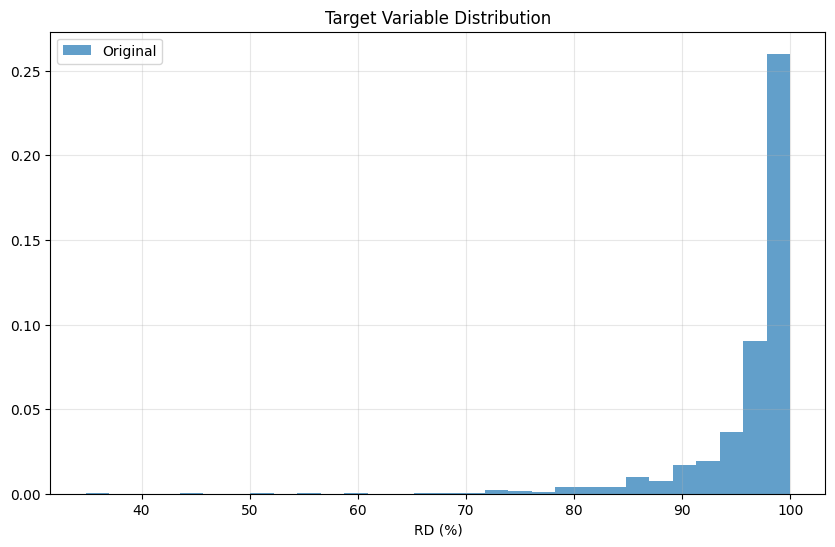

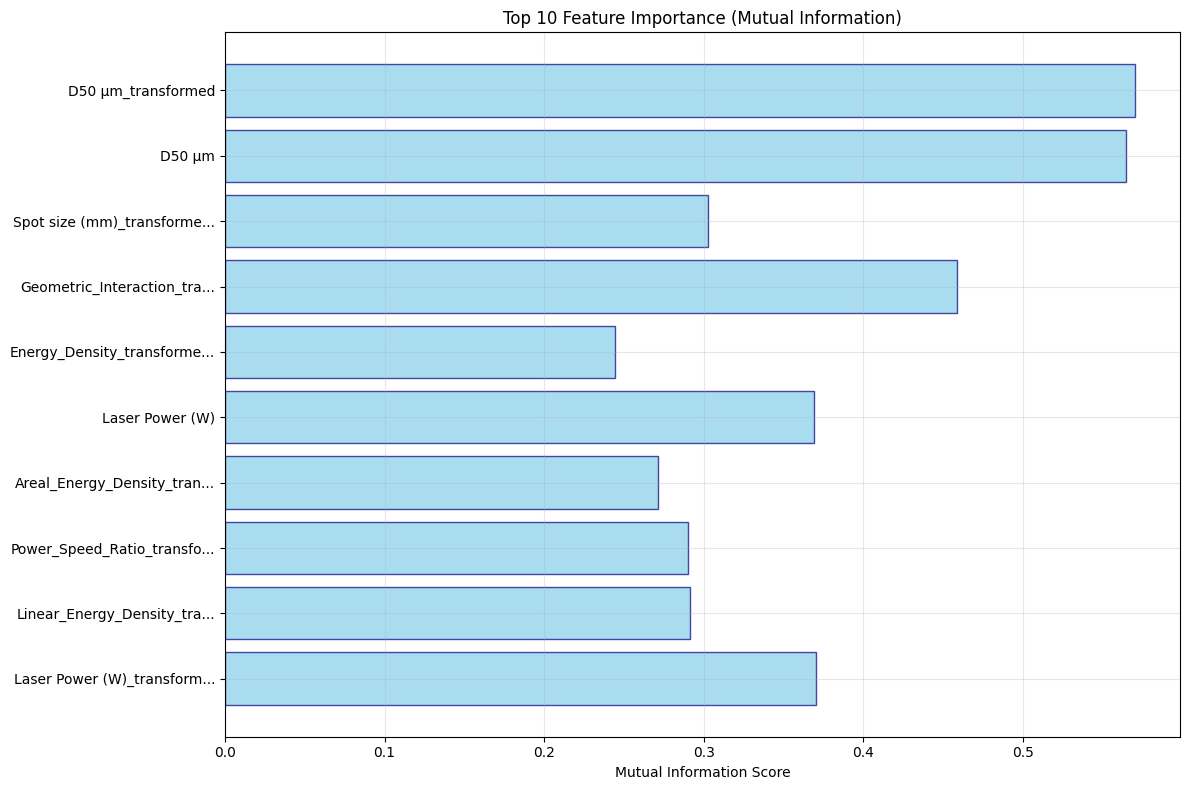

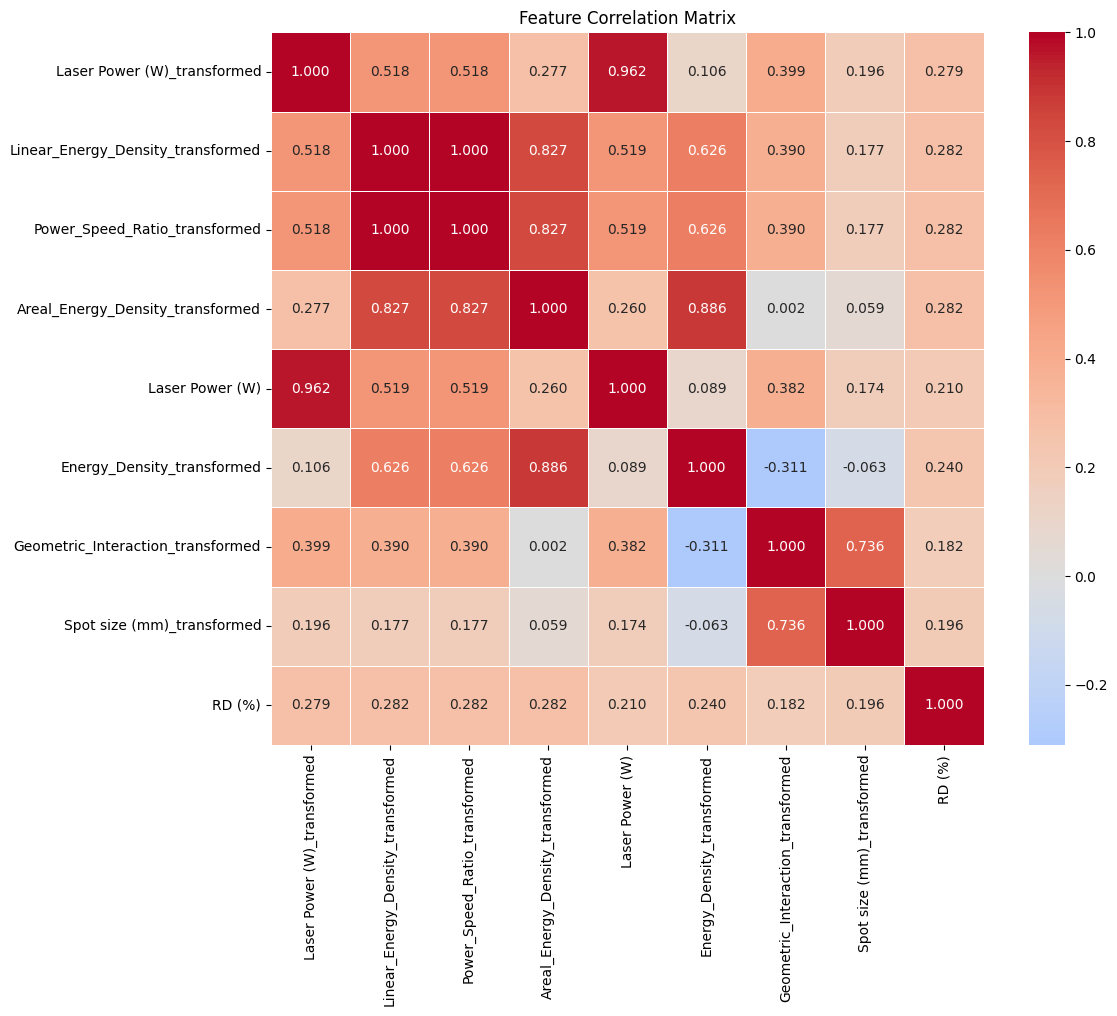

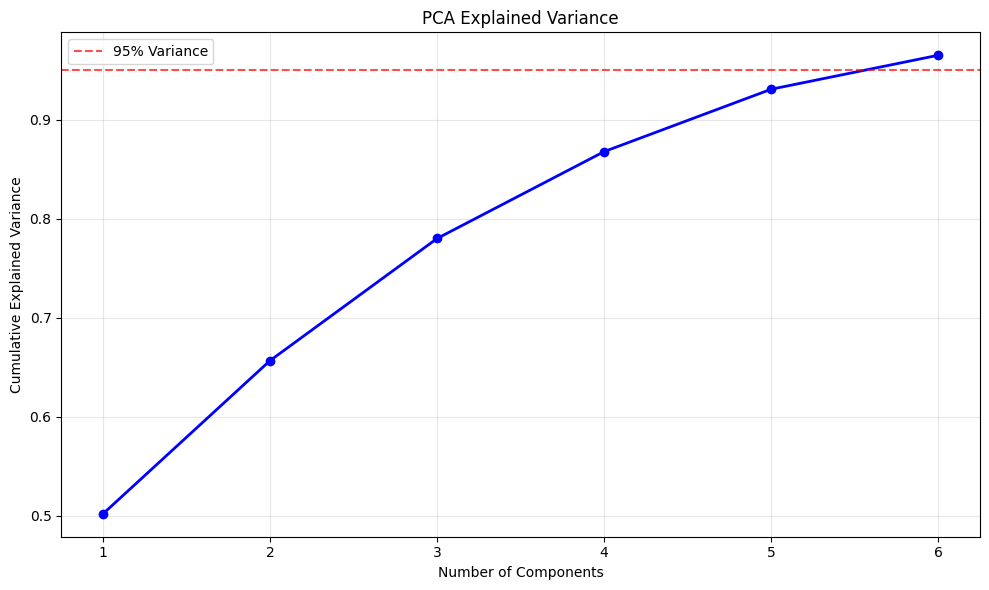

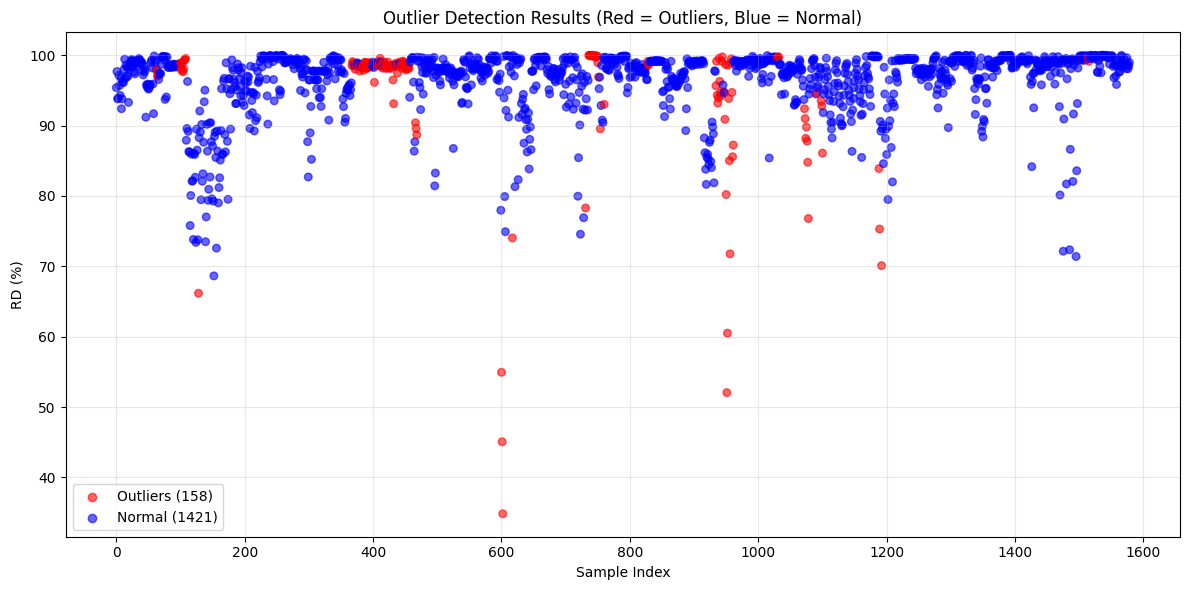

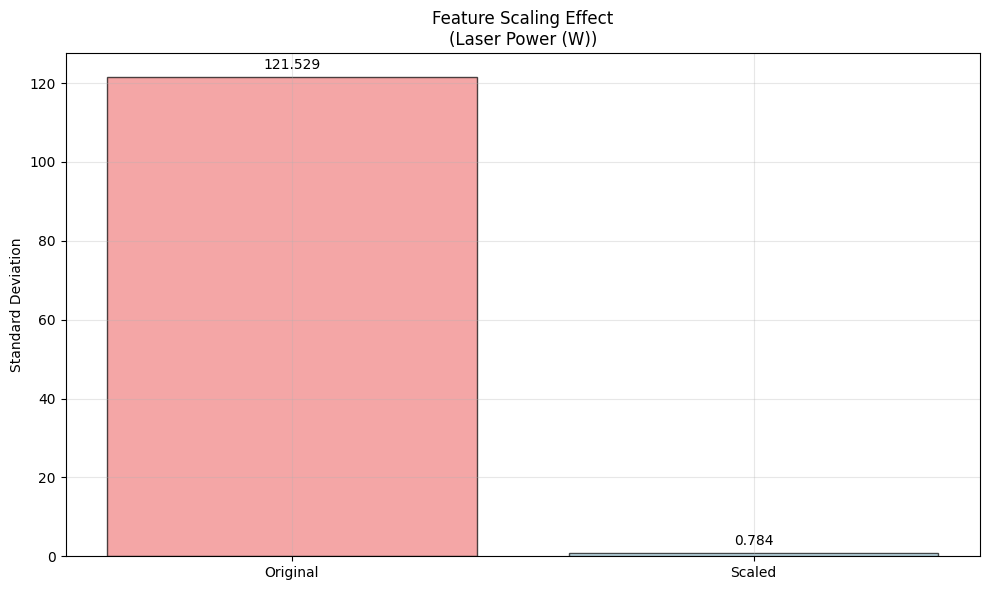

In [ ]:
# ============================================================================
# 8. VISUALIZATION OF PREPROCESSING RESULTS
# ============================================================================

def create_preprocessing_visualizations(df_original, df_processed, target_col='RD (%)',
                                      selected_features=None):
    """
    Create comprehensive visualizations of preprocessing results
    """
    print(f"\n=== CREATING PREPROCESSING VISUALIZATIONS ===")

    # Create separate plots vertically for better visibility

    # 1. Target variable distribution (before vs after)
    plt.figure(figsize=(10, 6))
    plt.hist(df_original[target_col].dropna(), bins=30, alpha=0.7, label='Original', density=True)

    # Check if transformed target exists
    transformed_target_col = f'{target_col}_transformed'
    if transformed_target_col in df_processed.columns:
        plt.hist(df_processed[transformed_target_col].dropna(),
                bins=30, alpha=0.7, label='Transformed', density=True)

    plt.title('Target Variable Distribution')
    plt.xlabel(target_col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2. Feature importance visualization
    if selected_features and 'feature_scores' in globals():
        plt.figure(figsize=(12, 8))
        mi_scores = [feature_scores['mutual_info'][feat] for feat in selected_features[:10]]
        feature_names = [feat[:25] + '...' if len(feat) > 25 else feat for feat in selected_features[:10]]

        plt.barh(range(len(mi_scores)), mi_scores, color='skyblue', edgecolor='navy', alpha=0.7)
        plt.yticks(range(len(mi_scores)), feature_names)
        plt.title('Top 10 Feature Importance (Mutual Information)')
        plt.xlabel('Mutual Information Score')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 3. Correlation heatmap of top features
    if selected_features:
        plt.figure(figsize=(12, 10))
        top_features_for_corr = selected_features[:8]  # Limit for visibility

        # Make sure all features exist in the processed dataframe
        available_features = [feat for feat in top_features_for_corr if feat in df_processed.columns]

        if available_features:
            corr_matrix = df_processed[available_features + [target_col]].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                       square=True, fmt='.3f', linewidths=0.5)
            plt.title('Feature Correlation Matrix')
            plt.tight_layout()
            plt.show()

    # 4. PCA explained variance
    if 'pca_model' in globals():
        plt.figure(figsize=(10, 6))
        cumulative_var = np.cumsum(pca_model.explained_variance_ratio_)
        plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'bo-', linewidth=2, markersize=6)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Explained Variance')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% Variance')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 5. Outlier detection results
    if 'outlier_results' in globals() and outlier_results and 'isolation_forest' in outlier_results:
        plt.figure(figsize=(12, 6))
        outlier_mask = outlier_results['isolation_forest'] == -1
        colors = ['red' if x else 'blue' for x in outlier_mask]
        plt.scatter(range(len(outlier_mask)), df_original[target_col],
                   c=colors, alpha=0.6, s=30)
        plt.title('Outlier Detection Results (Red = Outliers, Blue = Normal)')
        plt.xlabel('Sample Index')
        plt.ylabel(target_col)
        plt.grid(True, alpha=0.3)

        # Add legend
        plt.scatter([], [], c='red', alpha=0.6, label=f'Outliers ({np.sum(outlier_mask)})')
        plt.scatter([], [], c='blue', alpha=0.6, label=f'Normal ({np.sum(~outlier_mask)})')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 6. Feature scaling comparison
    if selected_features:
        plt.figure(figsize=(10, 6))

        # Find a feature that exists in both original and processed dataframes
        feature_to_compare = None
        for feat in selected_features:
            if feat in df_original.columns and feat in df_processed.columns:
                feature_to_compare = feat
                break

        if feature_to_compare:
            original_std = df_original[feature_to_compare].std()
            scaled_std = df_processed[feature_to_compare].std()

            bars = plt.bar(['Original', 'Scaled'], [original_std, scaled_std],
                          color=['lightcoral', 'lightblue'], edgecolor='black', alpha=0.7)
            plt.title(f'Feature Scaling Effect\n({feature_to_compare[:30]}{"..." if len(feature_to_compare) > 30 else ""})')
            plt.ylabel('Standard Deviation')
            plt.grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, value in zip(bars, [original_std, scaled_std]):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(original_std, scaled_std)*0.01,
                        f'{value:.3f}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

# Create visualizations
create_preprocessing_visualizations(df, df_scaled, selected_features=selected_features)

In [ ]:
# ============================================================================
# 9. FINAL PREPROCESSED DATASET
# ============================================================================

def create_final_dataset(df_scaled, selected_features, target_col='RD (%)',
                        include_pca=False, df_pca=None):
    """
    Create the final preprocessed dataset for modeling
    """
    print(f"\n=== CREATING FINAL PREPROCESSED DATASET ===")

    # Create final feature set
    final_features = selected_features.copy()

    # Add engineered features that were selected
    engineered_features = [col for col in df_scaled.columns
                          if any(keyword in col.lower() for keyword in
                                ['energy_density', 'thermal', 'overlap', 'interaction'])]

    # Include transformed features if they exist and were selected
    transformed_features = [col for col in df_scaled.columns if '_transformed' in col and col in selected_features]

    # Combine all features
    all_final_features = list(set(final_features + engineered_features + transformed_features))

    # Create final dataset
    final_dataset = df_scaled[all_final_features + [target_col]].copy()

    # Remove any remaining NaN values
    final_dataset = final_dataset.dropna()

    # Optionally include PCA features
    if include_pca and df_pca is not None:
        # Add PCA components
        pca_features = df_pca.columns.tolist()
        final_dataset_with_pca = pd.concat([
            final_dataset.reset_index(drop=True),
            df_pca.reset_index(drop=True)
        ], axis=1)

        print(f"Final dataset shape with PCA: {final_dataset_with_pca.shape}")
        print(f"Features included: {len(all_final_features)} original + {len(pca_features)} PCA components")

        return final_dataset, final_dataset_with_pca, all_final_features

    print(f"Final dataset shape: {final_dataset.shape}")
    print(f"Features included: {len(all_final_features)}")
    print(f"Samples after cleaning: {len(final_dataset)}")

    return final_dataset, all_final_features

# Create final datasets
final_dataset, final_dataset_with_pca, final_features = create_final_dataset(
    df_scaled, selected_features, include_pca=True, df_pca=df_pca
)




=== CREATING FINAL PREPROCESSED DATASET ===
Final dataset shape with PCA: (1579, 29)
Features included: 22 original + 6 PCA components


In [ ]:
# ============================================================================
# 10. EXPORT RESULTS
# ============================================================================

# Summary of preprocessing steps applied
preprocessing_summary = {
    'steps_applied': [
        'Advanced Outlier Detection (Isolation Forest)',
        'Domain-specific Feature Engineering',
        'Normality Testing and Transformation',
        'Robust Scaling',
        'Advanced Feature Selection (Multi-method)',
        'PCA Dimensionality Reduction',
        'Data Quality Assessment'
    ],
    'original_features': df.shape[1],
    'engineered_features': df_enhanced.shape[1] - df.shape[1],
    'final_features': len(final_features),
    'samples_retained': len(final_dataset),
    'data_quality_score': quality_report['missing_values']['percentage_complete']
}

print("\n" + "="*60)
print("PREPROCESSING SUMMARY")
print("="*60)
for key, value in preprocessing_summary.items():
    if isinstance(value, list):
        print(f"{key.replace('_', ' ').title()}:")
        for item in value:
            print(f"  ✓ {item}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")

print(f"\nFinal preprocessed dataset is ready for ML modeling!")
print(f"Use 'final_dataset' for modeling with selected features")
print(f"Use 'final_dataset_with_pca' for modeling with PCA components")


PREPROCESSING SUMMARY
Steps Applied:
  ✓ Advanced Outlier Detection (Isolation Forest)
  ✓ Domain-specific Feature Engineering
  ✓ Normality Testing and Transformation
  ✓ Robust Scaling
  ✓ Advanced Feature Selection (Multi-method)
  ✓ PCA Dimensionality Reduction
  ✓ Data Quality Assessment
Original Features: 14
Engineered Features: 7
Final Features: 22
Samples Retained: 1579
Data Quality Score: 100.0

Final preprocessed dataset is ready for ML modeling!
Use 'final_dataset' for modeling with selected features
Use 'final_dataset_with_pca' for modeling with PCA components


In [ ]:
# ============================================================================
# MACHINE LEARNING MODELING PIPELINE
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=== ML MODELING PIPELINE FOR LPBF RELATIVE DENSITY PREDICTION ===")
print(f"Final dataset shape: {final_dataset.shape}")
print(f"PCA dataset shape: {final_dataset_with_pca.shape}")



=== ML MODELING PIPELINE FOR LPBF RELATIVE DENSITY PREDICTION ===
Final dataset shape: (1579, 23)
PCA dataset shape: (1579, 29)


In [ ]:
# ============================================================================
# 1. DATA PREPARATION FOR MODELING
# ============================================================================

def prepare_modeling_data(dataset, target_col='RD (%)', test_size=0.2, random_state=42):
    """
    Prepare data for machine learning modeling
    """
    print(f"\n=== PREPARING DATA FOR MODELING ===")

    # Separate features and target
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target statistics:")
    print(f"  Mean: {y.mean():.4f}")
    print(f"  Std: {y.std():.4f}")
    print(f"  Range: {y.min():.4f} - {y.max():.4f}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=None
    )

    print(f"\nData split:")
    print(f"  Training set: {X_train.shape[0]} samples")
    print(f"  Testing set: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test, X.columns.tolist()

# Prepare both datasets
X_train, X_test, y_train, y_test, feature_names = prepare_modeling_data(final_dataset)
X_train_pca, X_test_pca, y_train_pca, y_test_pca, pca_feature_names = prepare_modeling_data(final_dataset_with_pca)




=== PREPARING DATA FOR MODELING ===
Features shape: (1579, 22)
Target shape: (1579,)
Target statistics:
  Mean: 96.3026
  Std: 5.4837
  Range: 34.8392 - 100.0000

Data split:
  Training set: 1263 samples
  Testing set: 316 samples

=== PREPARING DATA FOR MODELING ===
Features shape: (1579, 28)
Target shape: (1579,)
Target statistics:
  Mean: 96.3026
  Std: 5.4837
  Range: 34.8392 - 100.0000

Data split:
  Training set: 1263 samples
  Testing set: 316 samples


In [ ]:
# ============================================================================
# 2. MODEL DEFINITION AND HYPERPARAMETER SPACES
# ============================================================================

def get_model_configs():
    """
    Define models with their hyperparameter spaces for optimization
    """
    models = {


        'Random_Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },

        'Gradient_Boosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },

        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_child_weight': [1, 3, 5],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
        },

        'LightGBM': {
            'model': lgb.LGBMRegressor(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_child_samples': [5, 10, 20],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
        },


        'Extra_Trees': {
            'model': ExtraTreesRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        }
    }

    return models

# Get model configurations
model_configs = get_model_configs()
print(f"\nDefined {len(model_configs)} models for evaluation")


Defined 5 models for evaluation


In [ ]:
# ============================================================================
# 3. MODEL EVALUATION FUNCTIONS
# ============================================================================

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Comprehensive model evaluation
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }

    # Calculate overfitting score
    metrics['overfitting_score'] = metrics['train_r2'] - metrics['test_r2']

    return metrics, y_train_pred, y_test_pred

def cross_validate_model(model, X, y, cv=5, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']):
    """
    Perform cross-validation with multiple metrics
    """
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)

    results = {}
    for metric in scoring:
        results[f'cv_{metric}_mean'] = cv_results[f'test_{metric}'].mean()
        results[f'cv_{metric}_std'] = cv_results[f'test_{metric}'].std()

    return results



In [ ]:
# ============================================================================
# 4. HYPERPARAMETER OPTIMIZATION
# ============================================================================

def optimize_hyperparameters(model_configs, X_train, y_train, cv=5, n_iter=50):
    """
    Optimize hyperparameters for all models using RandomizedSearchCV
    """
    print(f"\n=== HYPERPARAMETER OPTIMIZATION ===")

    optimized_models = {}
    optimization_results = {}

    for model_name, config in model_configs.items():
        print(f"\nOptimizing {model_name}...")

        if config['params']:  # Only optimize if there are parameters to tune
            # Use RandomizedSearchCV for efficiency
            random_search = RandomizedSearchCV(
                config['model'],
                config['params'],
                n_iter=min(n_iter, 50),  # Limit iterations for faster execution
                cv=cv,
                scoring='r2',
                n_jobs=-1,
                random_state=42,
                verbose=0
            )

            random_search.fit(X_train, y_train)

            optimized_models[model_name] = random_search.best_estimator_
            optimization_results[model_name] = {
                'best_score': random_search.best_score_,
                'best_params': random_search.best_params_
            }

            print(f"  Best CV Score: {random_search.best_score_:.4f}")
            print(f"  Best Parameters: {random_search.best_params_}")

        else:  # No hyperparameters to tune
            optimized_models[model_name] = config['model']
            optimization_results[model_name] = {
                'best_score': None,
                'best_params': {}
            }
            print(f"  No hyperparameters to optimize")

    return optimized_models, optimization_results

# Optimize hyperparameters for both datasets
print("Optimizing models for original feature set...")
optimized_models, optimization_results = optimize_hyperparameters(model_configs, X_train, y_train)

print("\nOptimizing models for PCA feature set...")
optimized_models_pca, optimization_results_pca = optimize_hyperparameters(model_configs, X_train_pca, y_train_pca)



Optimizing models for original feature set...

=== HYPERPARAMETER OPTIMIZATION ===

Optimizing Random_Forest...
  Best CV Score: 0.7333
  Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}

Optimizing Gradient_Boosting...
  Best CV Score: 0.6854
  Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.2}

Optimizing XGBoost...
  Best CV Score: 0.7137
  Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Optimizing LightGBM...
  Best CV Score: 0.7121
  Best Parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}

Optimizing Extra_Trees...
  Best CV Score: 0.7431
  Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'm

In [ ]:
# ============================================================================
# 5. MODEL COMPARISON AND EVALUATION
# ============================================================================

def compare_models(optimized_models, X_train, X_test, y_train, y_test, dataset_name="Original"):
    """
    Compare all optimized models
    """
    print(f"\n=== MODEL COMPARISON - {dataset_name} DATASET ===")

    results_df = []
    model_predictions = {}

    for model_name, model in optimized_models.items():
        print(f"\nEvaluating {model_name}...")

        # Evaluate model
        metrics, y_train_pred, y_test_pred = evaluate_model(model, X_train, X_test, y_train, y_test)

        # Cross-validation
        cv_results = cross_validate_model(model, X_train, y_train)

        # Combine results
        result_row = {
            'Model': model_name,
            'Train_RMSE': metrics['train_rmse'],
            'Test_RMSE': metrics['test_rmse'],
            'Train_MAE': metrics['train_mae'],
            'Test_MAE': metrics['test_mae'],
            'Train_R2': metrics['train_r2'],
            'Test_R2': metrics['test_r2'],
            'Overfitting_Score': metrics['overfitting_score'],
            'CV_R2_Mean': cv_results['cv_r2_mean'],
            'CV_R2_Std': cv_results['cv_r2_std']
        }

        results_df.append(result_row)
        model_predictions[model_name] = {
            'y_train_pred': y_train_pred,
            'y_test_pred': y_test_pred
        }

        print(f"  Test R²: {metrics['test_r2']:.4f}")
        print(f"  Test RMSE: {metrics['test_rmse']:.4f}")
        print(f"  CV R² (mean±std): {cv_results['cv_r2_mean']:.4f}±{cv_results['cv_r2_std']:.4f}")

    results_df = pd.DataFrame(results_df)
    results_df = results_df.sort_values('Test_R2', ascending=False)

    return results_df, model_predictions

# Compare models for both datasets
results_original, predictions_original = compare_models(
    optimized_models, X_train, X_test, y_train, y_test, "Original Features"
)

results_pca, predictions_pca = compare_models(
    optimized_models_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca, "PCA Features"
)




=== MODEL COMPARISON - Original Features DATASET ===

Evaluating Random_Forest...
  Test R²: 0.6959
  Test RMSE: 3.4839
  CV R² (mean±std): 0.7333±0.0535

Evaluating Gradient_Boosting...
  Test R²: 0.7396
  Test RMSE: 3.2238
  CV R² (mean±std): 0.6854±0.0575

Evaluating XGBoost...
  Test R²: 0.7016
  Test RMSE: 3.4511
  CV R² (mean±std): 0.7137±0.0656

Evaluating LightGBM...
  Test R²: 0.6956
  Test RMSE: 3.4857
  CV R² (mean±std): 0.7121±0.0603

Evaluating Extra_Trees...
  Test R²: 0.6800
  Test RMSE: 3.5738
  CV R² (mean±std): 0.7431±0.0542

=== MODEL COMPARISON - PCA Features DATASET ===

Evaluating Random_Forest...
  Test R²: 0.7104
  Test RMSE: 3.3995
  CV R² (mean±std): 0.7312±0.0503

Evaluating Gradient_Boosting...
  Test R²: 0.7088
  Test RMSE: 3.4090
  CV R² (mean±std): 0.6885±0.0736

Evaluating XGBoost...
  Test R²: 0.7134
  Test RMSE: 3.3822
  CV R² (mean±std): 0.7096±0.0644

Evaluating LightGBM...
  Test R²: 0.6947
  Test RMSE: 3.4903
  CV R² (mean±std): 0.7120±0.0539

Eva

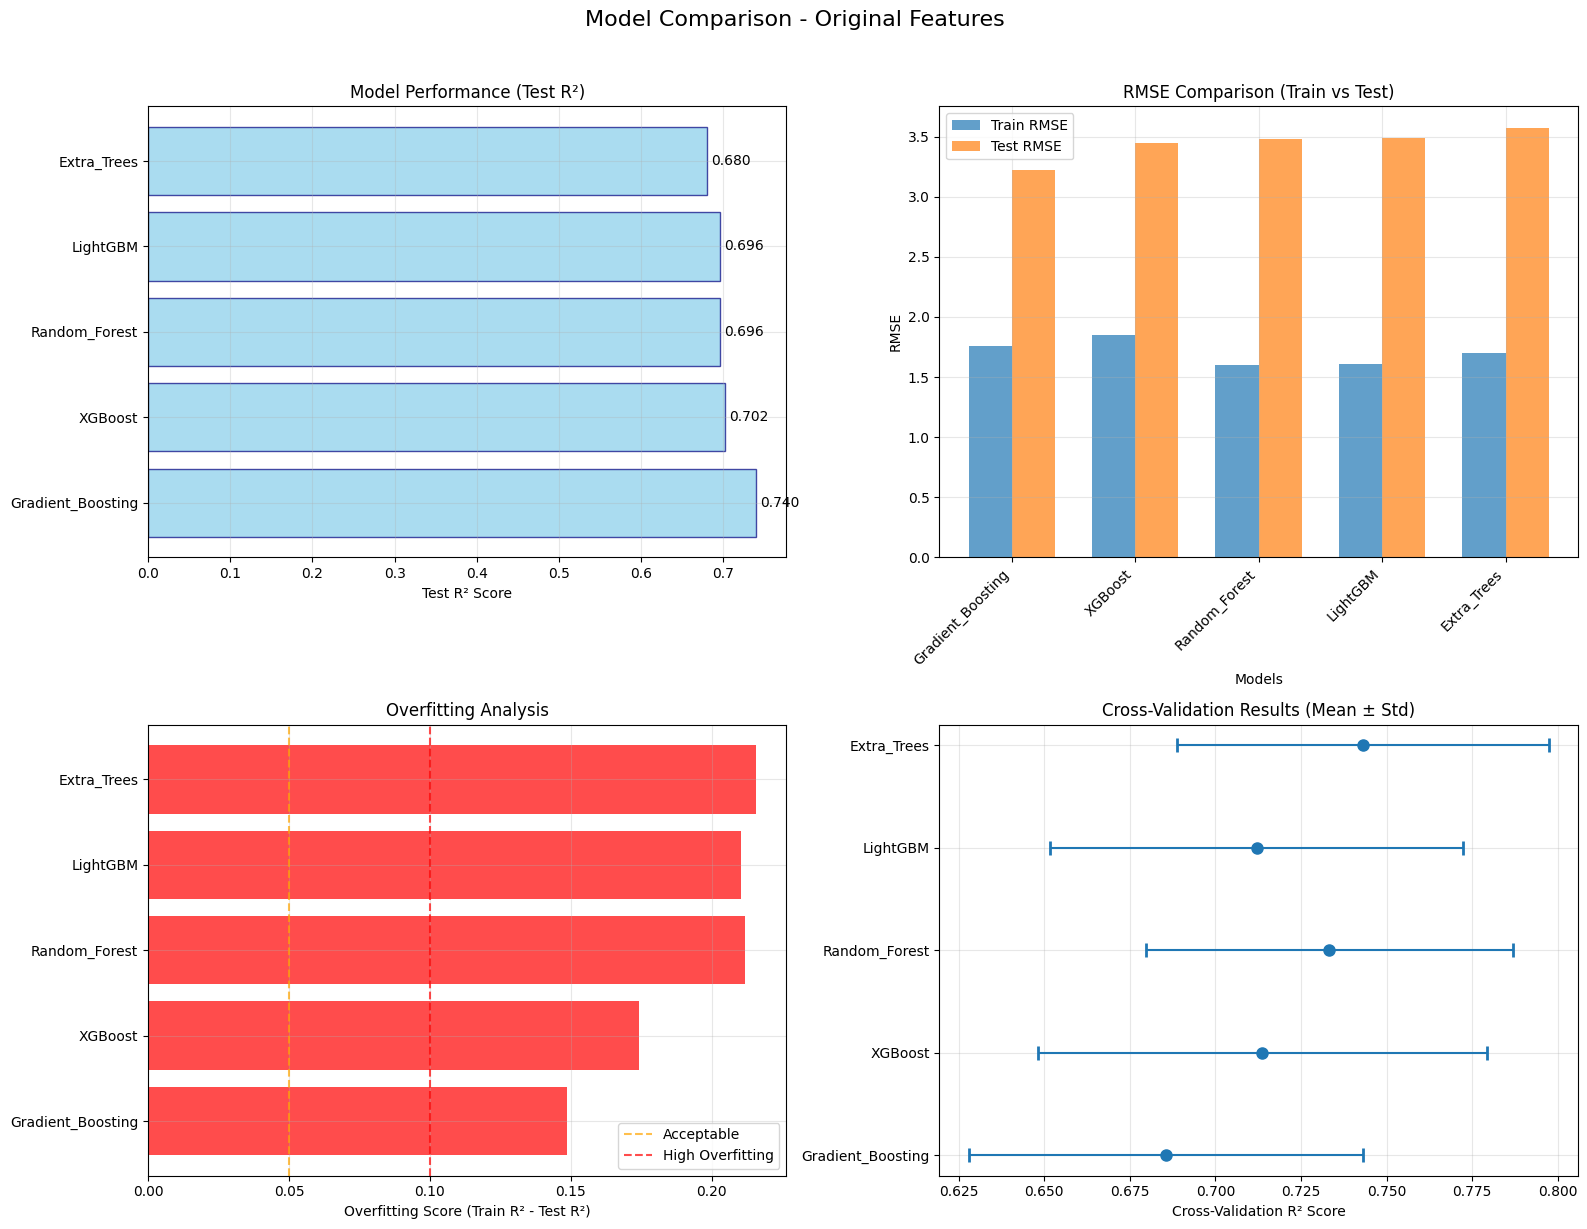

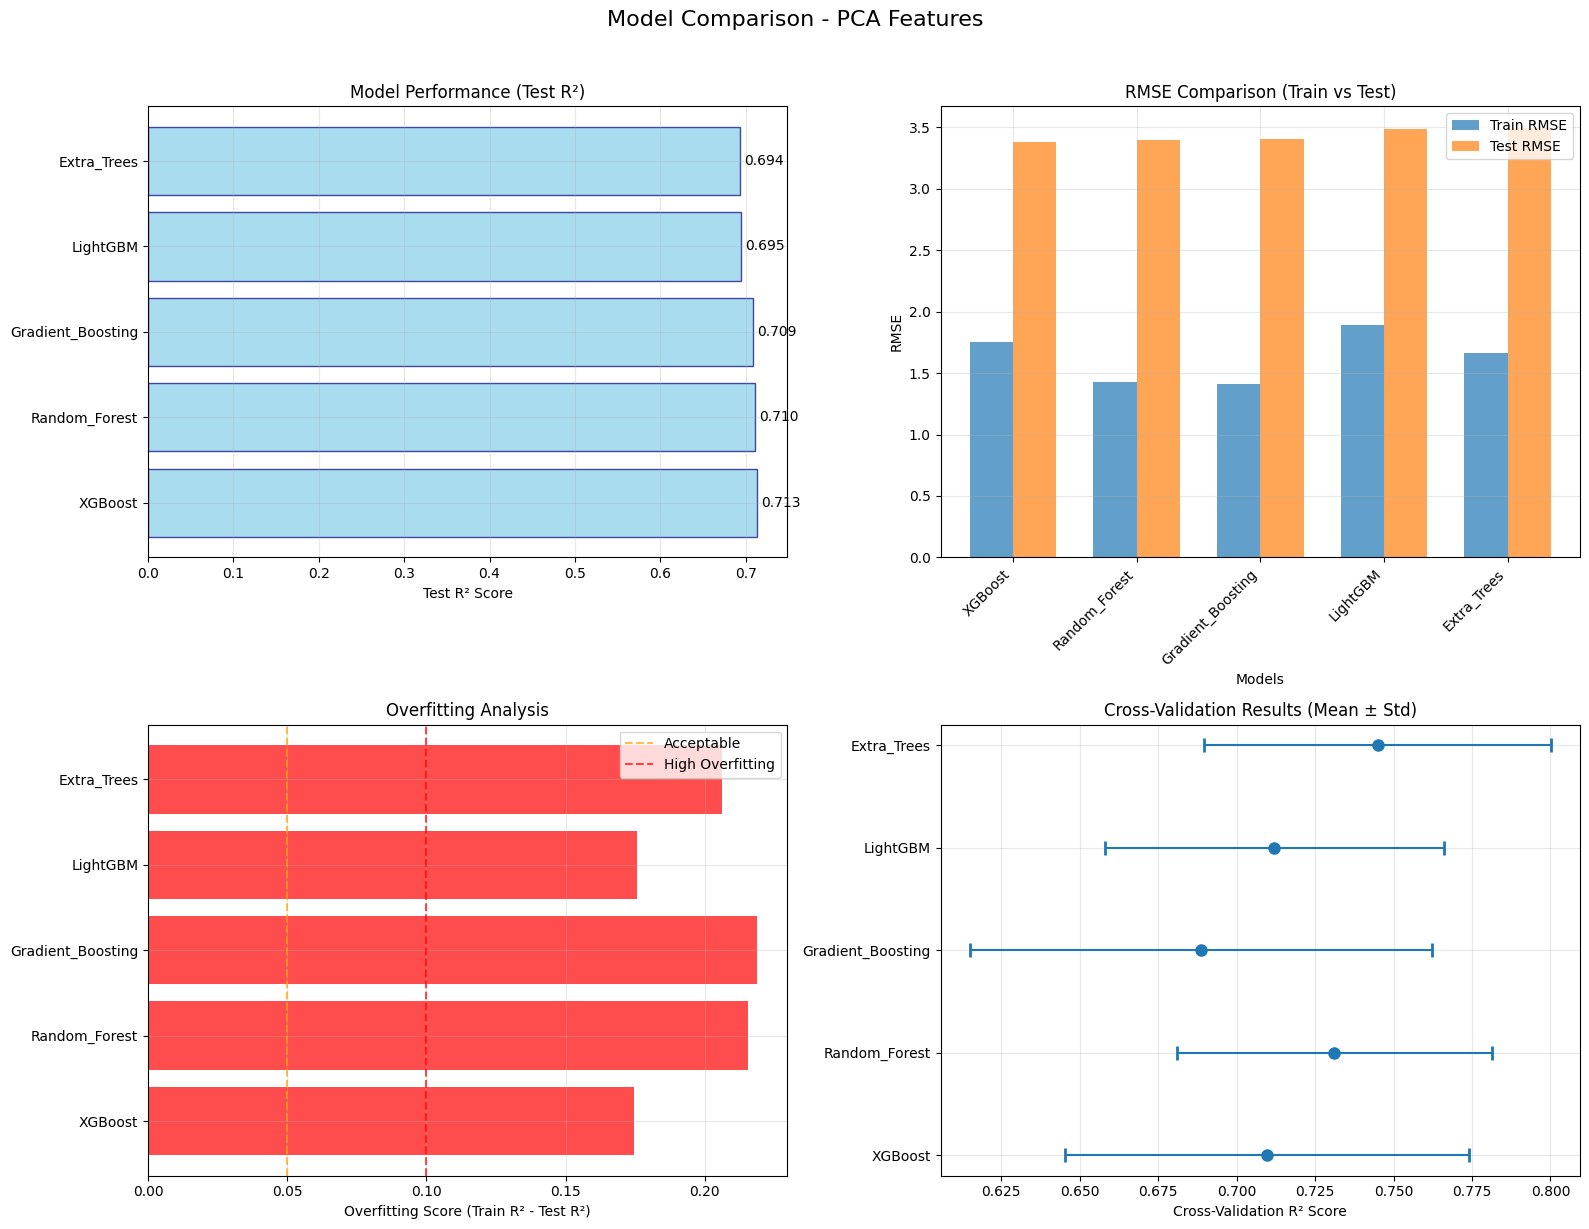

In [ ]:
# ============================================================================
# 6. RESULTS VISUALIZATION
# ============================================================================

def visualize_model_comparison(results_df, title="Model Comparison"):
    """
    Create comprehensive visualization of model comparison
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Test R² Score Comparison
    axes[0, 0].barh(results_df['Model'], results_df['Test_R2'], color='skyblue', edgecolor='navy', alpha=0.7)
    axes[0, 0].set_xlabel('Test R² Score')
    axes[0, 0].set_title('Model Performance (Test R²)')
    axes[0, 0].grid(True, alpha=0.3)

    # Add value labels
    for i, v in enumerate(results_df['Test_R2']):
        axes[0, 0].text(v + 0.005, i, f'{v:.3f}', va='center')

    # 2. RMSE Comparison
    x = np.arange(len(results_df))
    width = 0.35
    axes[0, 1].bar(x - width/2, results_df['Train_RMSE'], width, label='Train RMSE', alpha=0.7)
    axes[0, 1].bar(x + width/2, results_df['Test_RMSE'], width, label='Test RMSE', alpha=0.7)
    axes[0, 1].set_xlabel('Models')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].set_title('RMSE Comparison (Train vs Test)')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Overfitting Analysis
    colors = ['red' if x > 0.1 else 'green' if x < 0.05 else 'orange' for x in results_df['Overfitting_Score']]
    axes[1, 0].barh(results_df['Model'], results_df['Overfitting_Score'], color=colors, alpha=0.7)
    axes[1, 0].set_xlabel('Overfitting Score (Train R² - Test R²)')
    axes[1, 0].set_title('Overfitting Analysis')
    axes[1, 0].axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Acceptable')
    axes[1, 0].axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='High Overfitting')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Cross-Validation Results
    axes[1, 1].errorbar(results_df['CV_R2_Mean'], range(len(results_df)),
                       xerr=results_df['CV_R2_Std'], fmt='o', capsize=5, capthick=2, markersize=8)
    axes[1, 1].set_yticks(range(len(results_df)))
    axes[1, 1].set_yticklabels(results_df['Model'])
    axes[1, 1].set_xlabel('Cross-Validation R² Score')
    axes[1, 1].set_title('Cross-Validation Results (Mean ± Std)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_model_comparison(results_original, "Model Comparison - Original Features")
visualize_model_comparison(results_pca, "Model Comparison - PCA Features")



In [ ]:
# ============================================================================
# 7. DISPLAY RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION SUMMARY")
print("="*80)

print("\n--- ORIGINAL FEATURES DATASET ---")
print(results_original.round(4).to_string(index=False))

print("\n--- PCA FEATURES DATASET ---")
print(results_pca.round(4).to_string(index=False))

# Find best models
best_original = results_original.iloc[0]
best_pca = results_pca.iloc[0]

print(f"\n--- BEST PERFORMING MODELS ---")
print(f"Original Features: {best_original['Model']} (Test R² = {best_original['Test_R2']:.4f})")
print(f"PCA Features: {best_pca['Model']} (Test R² = {best_pca['Test_R2']:.4f})")

if best_original['Test_R2'] > best_pca['Test_R2']:
    print(f"\nRecommendation: Use Original Features with {best_original['Model']}")
    best_overall_model = optimized_models[best_original['Model']]
    best_dataset = "Original"
else:
    print(f"\nRecommendation: Use PCA Features with {best_pca['Model']}")
    best_overall_model = optimized_models_pca[best_pca['Model']]
    best_dataset = "PCA"

print(f"\nNext steps: Feature importance analysis and prediction analysis for the best model")


MODEL EVALUATION SUMMARY

--- ORIGINAL FEATURES DATASET ---
            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  Overfitting_Score  CV_R2_Mean  CV_R2_Std
Gradient_Boosting      1.7559     3.2238     0.9938    1.5270    0.8882   0.7396             0.1486      0.6854     0.0575
          XGBoost      1.8514     3.4511     1.0539    1.5389    0.8757   0.7016             0.1741      0.7137     0.0656
    Random_Forest      1.5970     3.4839     0.7235    1.4370    0.9075   0.6959             0.2117      0.7333     0.0535
         LightGBM      1.6115     3.4857     0.7915    1.5757    0.9058   0.6956             0.2103      0.7121     0.0603
      Extra_Trees      1.6963     3.5738     0.7738    1.3886    0.8957   0.6800             0.2157      0.7431     0.0542

--- PCA FEATURES DATASET ---
            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  Overfitting_Score  CV_R2_Mean  CV_R2_Std
          XGBoost      1.7569     3.3822     0.9